Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [ ]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [ ]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


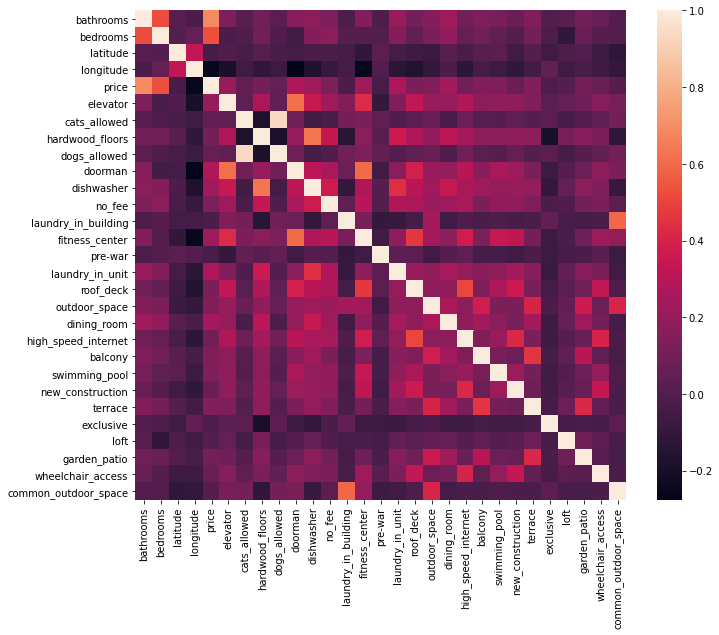

In [ ]:
# Let's get a sense for which columns correlate
import seaborn as sms
import matplotlib.pyplot as plt

plt.figure(figsize=(11,9))
sms.heatmap(df.corr())

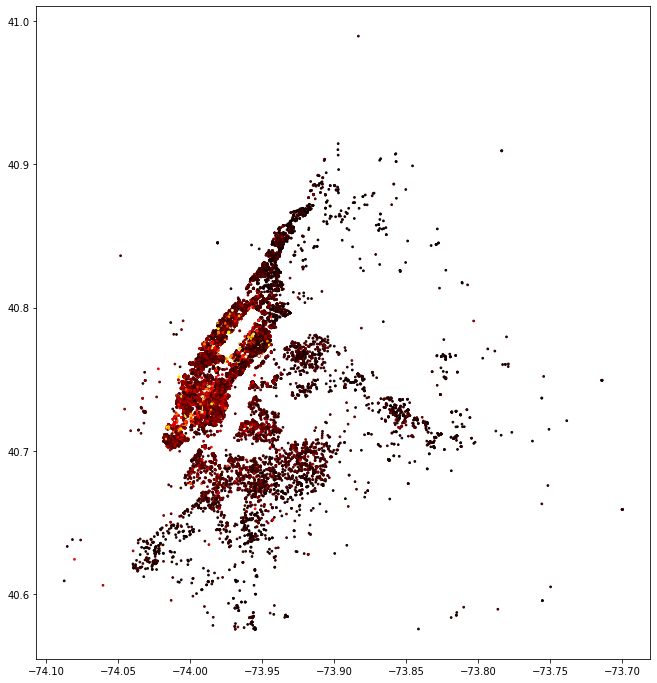

In [ ]:
# I can't resist making a map when there's latitude and longitude columns!
import matplotlib.pyplot as plt
plt.figure(figsize=(11,12))
plt.scatter(df.longitude, df.latitude, c=df.price, cmap='hot',s=3)

In [ ]:
# Split the data by date, using data before June 2016 to train and later dates to test.
train_mask = df['created'] < '2016-06-01'
(train, test) = df[train_mask], df[~train_mask]
print('train shape =',train.shape)
print('test shape =',test.shape)

train shape = (31844, 35)
test shape = (16973, 35)


In [ ]:
# A function which prints all the error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def print_error_metrics(y_ground, y_pred):

  # MAE
  mae = mean_absolute_error(y_ground, y_pred)
  print('MAE = $'+format(mae, '.2f'))

  # RMSD
  rmsd = np.sqrt(mean_squared_error(y_ground, y_pred))
  print('RMSD = $'+format(rmsd, '.2f'))

  # R^2
  r2 = r2_score(y_ground, y_pred)
  print('Training R^2:', format(r2,'.3f'),'out of 1.000')

In [ ]:
# Make and test a baseline model based on the median price

train_med = train['price'].median()
print('Median rent = $'+format(train_med,'.2f'))

# Calculate the error metrics
y_train = train['price']
y_predict = np.full(y_train.shape, train_med)
print('\nError for the training set:')
print_error_metrics(y_train, y_predict)

y_test = test['price']
y_predict = np.full(y_test.shape, train_med)
print('\nError for the testing set:')
print_error_metrics(y_test, y_predict)

Median rent = $3150.00

Error for the training set:
MAE = $1138.52
RMSD = $1812.78
Training R^2: -0.058 out of 1.000

Error for the testing set:
MAE = $1136.66
RMSD = $1816.33
Training R^2: -0.061 out of 1.000


In [ ]:
# Make a linear model based on the number of bedrooms and bathrooms

# Subset the data into X and y
X_train = train[['bathrooms', 'bedrooms']]
X_test =   test[['bathrooms', 'bedrooms']]
y_train = train['price']
y_test =   test['price']

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
B = [model.intercept_, *model.coef_]

# Print in equation form
print('A linear model based on the number of bedrooms and bathrooms')
print('Apartment price ($) = $'+format(B[0],'.2f')+' + $'+format(B[1],'.2f')+ ' * (# of bathrooms) + $'+format(B[2],'.2f')+' * (# of bedrooms)')

# Calculate the error metrics
print('\nError for the training set:')
y_predict = model.predict(X_train)
print_error_metrics(y_train, y_predict)

print('\nError for the testing set:')
y_predict = model.predict(X_test)
print_error_metrics(y_test, y_predict)

A linear model based on the number of bedrooms and bathrooms
Apartment price ($) = $485.72 + $2072.61 * (# of bathrooms) + $389.32 * (# of bedrooms)

Error for the training set:
MAE = $818.53
RMSD = $1232.02
Training R^2: 0.511 out of 1.000

Error for the testing set:
MAE = $825.90
RMSD = $1219.72
Training R^2: 0.521 out of 1.000


In [ ]:
# Make a new feature that combines bedrooms and bathrooms.
# Since the model above revealed that bathrooms are worth ~5x more than bedrooms
# Multiply bathrooms by that factor in the combined feature
bath_price = B[1]
bed_price =  B[2]
bath_bed_price_ratio = bath_price / bed_price
df['rooms'] = bath_bed_price_ratio * df['bathrooms'] + df['bedrooms']
df['rooms'].describe()

count    48817.000000
mean         7.935022
std          3.226155
min          0.000000
25%          6.323600
50%          6.323600
75%          8.323600
max         55.236003
Name: rooms, dtype: float64

In [ ]:
# Make a feature for the distance from city center
# Defined as the weighted average of rent prices

# First calculate the weighted average of rent prices
price_weights = df.price / df.price.sum()
center_longitude = np.dot(df.longitude, price_weights)
center_latitude = np.dot(df.latitude, price_weights)
print('Rent centroid =',format(center_latitude,'.3f')+', '+format(center_longitude,'.3f'))

# Then compute the distance from that point
# Remember that longitude lines are closer together than latitude:
longitude_scale = np.cos(df.latitude.mean() * (np.pi/180))

def distance_from_core(lon, lat):
  d_lon = (lon - center_longitude) * longitude_scale
  d_lat = lat - center_latitude
  distance = np.linalg.norm([d_lat, d_lon])
  return np.log(distance)
df['distance_from_center'] = df.apply(lambda x: distance_from_core(lon = x['longitude'], lat = x['latitude']), axis=1)
train['distance_from_center'].describe()

Rent centroid = 40.750, -73.976


count    31844.000000
mean         0.035264
std          0.027163
min          0.000386
25%          0.017099
50%          0.027980
75%          0.047005
max          0.228135
Name: distance_from_center, dtype: float64

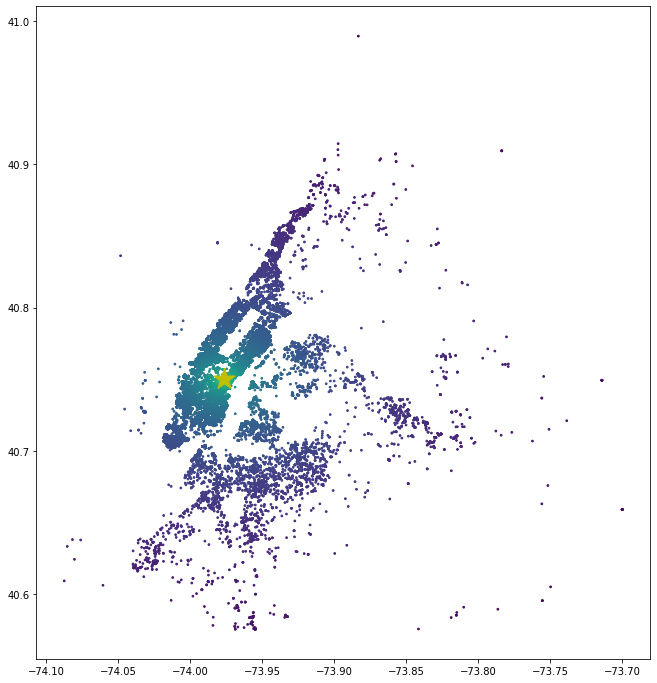

In [ ]:
# Plot the centroid of high rent and distance from that centroid
# To make sure it's working properly
import matplotlib.pyplot as plt
plt.figure(figsize=(11,12))
plt.scatter(df.longitude, df.latitude, c=df.distance_from_center, cmap='viridis_r',s=3)
plt.scatter([center_longitude], [center_latitude], s=500, c='y', marker='*')

In [ ]:
# We've added two new features to df, so we need to train/test split again
(train, test) = df[train_mask], df[~train_mask]

In [ ]:
# Plot these new features vs Rent
import plotly.express as px

px.scatter_3d(train, x='rooms', y='distance_from_center', z='price',
           title='NYC Rental Prices' )

In [ ]:
# Make the model based on distance from city center and # of rooms

# Subset the data into X and y
X_train = train[['rooms', 'distance_from_center']]
X_test =   test[['rooms', 'distance_from_center']]
y_train = train['price']
y_test =   test['price']

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
B = [model.intercept_, *model.coef_]

# Print in equation form
print('A linear model based on distance from city center and # of rooms')
print('Apartment price ($) = $'+format(B[0],'.2f')+' + $'+format(B[1],'.2f')+ ' * (5.3*Baths + Beds) + $'+format(B[2],'.2f')+' * ln(Distance from City Center)')

# Calculate the error metrics
print('\nError for the training set:')
y_predict = model.predict(X_train)
print_error_metrics(y_train, y_predict)

print('\nError for the testing set:')
y_predict = model.predict(X_test)
print_error_metrics(y_test, y_predict)

A linear model based on distance from city center and # of rooms
Apartment price ($) = $-934.29 + $389.75 * (5.3*Baths + Beds) + $-390.04 * ln(Distance from City Center)

Error for the training set:
MAE = $786.78
RMSD = $1190.52
Training R^2: 0.544 out of 1.000

Error for the testing set:
MAE = $789.20
RMSD = $1175.89
Training R^2: 0.555 out of 1.000


My Model MAEs:

- $1136.66 = Simple Median

- $825.90 = Bed & Bath

- $789.20 = City Center and # of Rooms